In [4]:
#Loading data
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

# Model Validation

In [5]:
#Define model
from sklearn.neighbors import KNeighborsClassifier #Classifier
from sklearn.metrics import accuracy_score #Evaluation metric
knn = KNeighborsClassifier(n_neighbors=1)
#Baseline model to compare - Training with the whole dataset
knn.fit(X,y)
y_pred = knn.predict(X)
accuracy_score(y, y_pred)

1.0

#### Holdout sets

In [7]:
from sklearn.model_selection import train_test_split
# Split the data with 50% in each set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, 
                                                    random_state=42)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.97333333333333338

#### Cross Validation

In [8]:
# Testing 2-fold cross validation since the holdout set was 50%
y2_model = knn.fit(X_train, y_train).predict(X_test)
y1_model = knn.fit(X_test, y_test).predict(X_train)
accuracy_score(y_test, y2_model), accuracy_score(y_train, y1_model)

(0.97333333333333338, 0.93333333333333335)

In [11]:
#Real Cross Validation
from sklearn.model_selection import cross_val_score
cross_val_score(knn, X_train, y_train, cv=5)

array([ 0.94117647,  0.875     ,  1.        ,  1.        ,  0.85714286])

In [24]:
# Extreme case: # of folds = # of datapoints
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(knn, X_train, y_train, cv=loo)
print(scores, 'with mean: ', scores.mean())

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.
  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.
  1.  1.  1.] with mean:  0.92


# Model Selection

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [29]:
def PolynomialRegression(degree=1, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), 
                         LinearRegression(**kwargs))

In [30]:
import numpy as np
def make_data(N, err=1.0, rseed=1):
    #randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1 / (X.ravel() + 0.1)
    if err > 0:
        y+=err*rng.randn(N)
    return X,y
X, y = make_data(40)

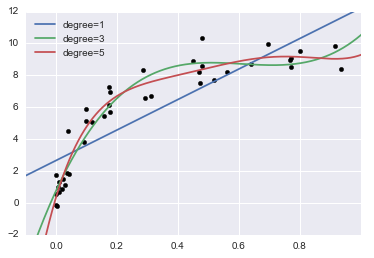

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() #plot formatting
X_test = np.linspace(-0.1, 1.1, 500)[:, None]
plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X,y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

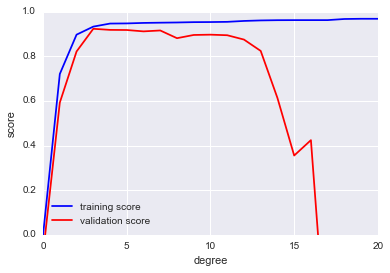

In [35]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                         'polynomialfeatures__degree',
                                         degree, cv=7)
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0,1)
plt.xlabel('degree')
plt.ylabel('score');

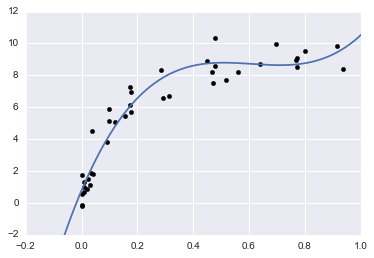

In [37]:
# From the validation curve, optimum degree = 3
plt.scatter(X.ravel(), y, color='black')
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X,y).predict(X_test)
plt.plot(X_test.ravel(), y_test)
plt.axis(lim);

# Learning Curves

Measures how the model responds to increasing training data

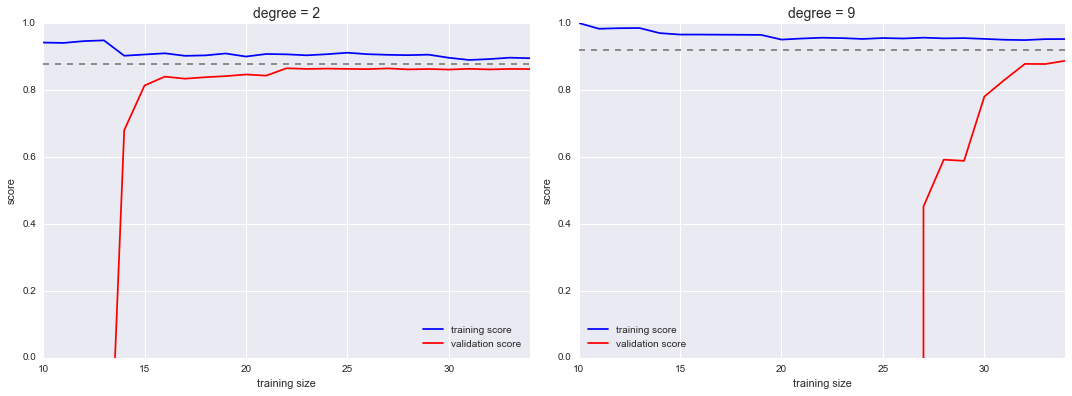

In [39]:
from sklearn.model_selection import learning_curve
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2,9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree), 
                                         X, y, cv=7, 
                                         train_sizes=np.linspace(0.3, 1, 25))
    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray',
                linestyle='dashed')
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

# Grid Search

In [40]:
from sklearn.model_selection import GridSearchCV
param_grid = {'polynomialfeatures__degree': np.arange(21),
               'linearregression__fit_intercept': [True, False],
               'linearregression__normalize':[True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)
grid.fit(X,y)
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

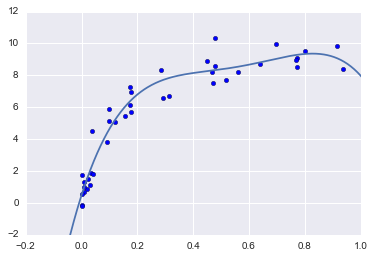

In [41]:
model = grid.best_estimator_
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X,y).predict(X_test)
plt.plot(X_test.ravel(), y_test, hold=True);
plt.axis(lim);